In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
import gensim
import sqlite3

#metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import pickle

def save(obj,fn):
    pickle.dump(obj,open(fn+".p","wb"))
    
def read(fn):
    temp=pickle.load(open(fn+".p","rb"))
    return temp


In [3]:
#reading sql file and creating dataframe
df=pd.read_csv("final.csv")
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud- nice rhythm well ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [4]:
df=df.sample(100000)

In [5]:
#sorting file
df.sort_values("Time",inplace=True)
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
215,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap &quot;...
296,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuic awe-inspir wonder amus comed romp e...
425,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton bring distinguish characterist ...


# Bag Of Words

In [7]:
#unigram
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

#breaking data into train and test
X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to unigram
unigram=CountVectorizer(max_features=45452)
bow_train=unigram.fit_transform(X_train)
bow_test=unigram.transform(X_test)

#normalize
bow_train=preprocessing.normalize(bow_train)
bow_test=preprocessing.normalize(bow_test)
print("shape of train ",bow_train.shape)
print("shape of test ",bow_test.shape)


shape of train  (70000, 45022)
shape of test  (30000, 45022)


In [8]:
#10 fold cross validation

from sklearn.model_selection import TimeSeriesSplit

tscv=TimeSeriesSplit(n_splits=10)
for train,cv in tscv.split(bow_train):
    print(bow_train[train].shape,bow_train[cv].shape)

(6370, 45022) (6363, 45022)
(12733, 45022) (6363, 45022)
(19096, 45022) (6363, 45022)
(25459, 45022) (6363, 45022)
(31822, 45022) (6363, 45022)
(38185, 45022) (6363, 45022)
(44548, 45022) (6363, 45022)
(50911, 45022) (6363, 45022)
(57274, 45022) (6363, 45022)
(63637, 45022) (6363, 45022)


# Grid Search

### with L2 reg

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l2']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,scoring='roc_auc',verbose=1)
gsv.fit(bow_train,Y_train)

print("best parameter :",gsv.best_params_)
print("best_score %.2ff%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.8min finished


best parameter : {'C': 1, 'penalty': 'l2'}
best_score 93.08f%


In [9]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

In [10]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [11]:
X=np.log(C)
X

array([-11.51292546,  -9.21034037,  -6.90775528,  -4.60517019,
        -2.30258509,   0.        ,   2.30258509,   4.60517019,
         6.90775528,   9.21034037])

In [12]:
print(gsv.cv_results_['params'])

[{'C': 1e-05, 'penalty': 'l2'}, {'C': 0.0001, 'penalty': 'l2'}, {'C': 0.001, 'penalty': 'l2'}, {'C': 0.01, 'penalty': 'l2'}, {'C': 0.1, 'penalty': 'l2'}, {'C': 1, 'penalty': 'l2'}, {'C': 10, 'penalty': 'l2'}, {'C': 100, 'penalty': 'l2'}, {'C': 1000, 'penalty': 'l2'}, {'C': 10000, 'penalty': 'l2'}]


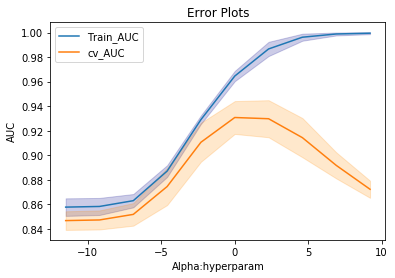

In [13]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [14]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l2',class_weight='balanced')

clf.fit(bow_train,Y_train)
Y_pred1=clf.predict(bow_train)
Y_pred2=clf.predict(bow_test)

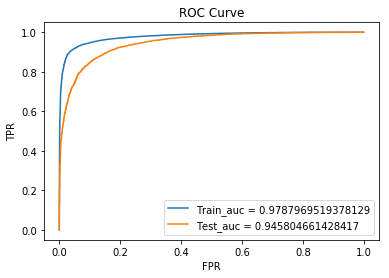

In [15]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(bow_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

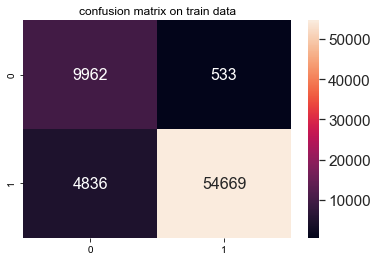

In [16]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

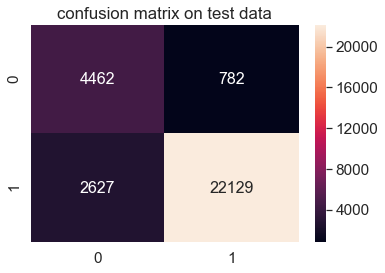

In [17]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [18]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-3.73637118e+00  2.32287295e+00  1.10636044e-02 -1.72402046e-01
  2.01463018e-01  2.01463018e-01 -7.09414196e-03  1.45928930e-02
  1.15245797e-01 -5.39158374e-01 -1.65805273e-02  5.89133899e-03
  2.49506136e-01  1.32260646e-02  6.74028543e-01  2.21823496e-01
 -1.21902548e+00  2.25338338e-01  2.25829218e-01  2.62535397e-01
 -2.23987269e-01 -2.08748307e-01 -1.32617002e-02  3.91283675e-02
  5.71552389e-02  7.46353074e-02  3.13206519e-01  3.21734197e-01
 -1.08330413e-01  1.28204685e-01 -2.81403472e+00  1.99300902e-02
  1.52689657e-01  3.48404536e-02  2.14120555e-02 -3.75839722e-01
 -3.75839722e-01 -3.61631322e-02  3.73533639e-03  1.41673537e-01
  6.41570280e-02  1.96675674e-02  3.62731801e-02  1.25432977e-01
 -9.16208941e-01 -4.19712688e+00  2.01463018e-01 -4.62725478e-01
 -1.10518431e+00  6.59096878e-02]


In [19]:
X_train_t = bow_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b] 

In [20]:
#Training on train data having random noise

clf = LogisticRegression(C= 10, penalty= 'l2',class_weight='balanced')
clf.fit(X_train_t,Y_train)
Y_pred = clf.predict(bow_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.633%
Non Zero weights: 45452


In [21]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-3.73614730e+00  2.32268164e+00  1.10686988e-02 -1.72173372e-01
  2.01406528e-01  2.01576519e-01 -7.10436276e-03  1.46202160e-02
  1.15129969e-01 -5.39346889e-01 -1.66074852e-02  5.89689426e-03
  2.49471333e-01  1.32105119e-02  6.74011586e-01  2.22015452e-01
 -1.22102446e+00  2.25560800e-01  2.25864183e-01  2.62473628e-01
 -2.23892260e-01 -2.07661750e-01 -1.32780749e-02  3.90423238e-02
  5.71402320e-02  7.45894969e-02  3.13228701e-01  3.23404693e-01
 -1.08946701e-01  1.28372759e-01 -2.81322390e+00  1.98883114e-02
  1.52898563e-01  3.48028861e-02  2.14085190e-02 -3.76281375e-01
 -3.76164082e-01 -3.58373893e-02  3.72726864e-03  1.41836618e-01
  6.40893401e-02  1.96081712e-02  3.62624395e-02  1.25225510e-01
 -9.16318820e-01 -4.19641225e+00  2.01729551e-01 -4.63525873e-01
 -1.10755217e+00  6.59170963e-02]


In [22]:
weights1 += 0.00000001
weights2 += 0.00000001

In [23]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [24]:
print(weights_diff[np.where(weights_diff > 30)].size)

16


In [28]:
bow_train.shape

(70000, 45452)

In [29]:
a=np.arange(1,45023)
a.shape

(45452,)

In [30]:
j=[]
for i in range(10,110,10):
    j.append(int(round(np.percentile(a,i),0))-1)
    
weights_diff[[i for i in j]]

array([-0.12189254,  0.11029313,  0.04347761, -0.14615691,  0.06729393,
        0.09334191,  0.00344927,  0.13909157,  0.16731259,  0.15956924])

#### Observation:-
There is no sudden rise in quantile of weights_diff vector

In [31]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tpositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(unigram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						positive
________________________________________________________________________________________________
	-18.0531	worst          				10.8020	hook           
	-12.3357	terribl        				10.4015	skeptic        
	-11.9629	disapoint      				9.7136	beat           
	-11.7593	aw             				9.6260	yummi          
	-10.9337	threw          				9.4484	delici         
	-10.5181	horribl        				9.0496	excel          
	-10.4459	disgust        				9.0080	perfect        
	-10.4338	unfortun       				8.9915	addict         
	-10.1797	bland          				8.7169	yum            
	-10.1311	stale          				8.4589	worri          
	-10.1083	disappoint     				8.3052	amaz           
	-9.8742	return         				8.2586	best           
	-9.7904	unpleas        				7.9354	heaven         
	-9.5066	concept        				7.7204	fantast        
	-9.4869	tasteless      				7.6650	smooth         
	-9.2364	nespresso      				7.5875	complaint      
	-9.1376	mediocr        				7.5538	awesom       

### with L1 reg

In [170]:
clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l1']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,scoring='roc_auc',verbose=1)
gsv.fit(bow_train,Y_train)

print("best parameter :",gsv.best_params_)
print("best_score %.2ff%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 37.0min finished


best parameter : {'C': 1, 'penalty': 'l1'}
best_score 92.97f%


In [171]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

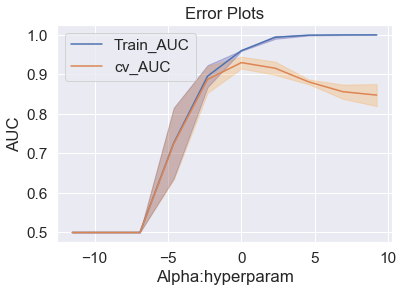

In [172]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [204]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')

clf.fit(bow_train,Y_train)
Y_pred1=clf.predict(bow_train)
Y_pred2=clf.predict(bow_test)

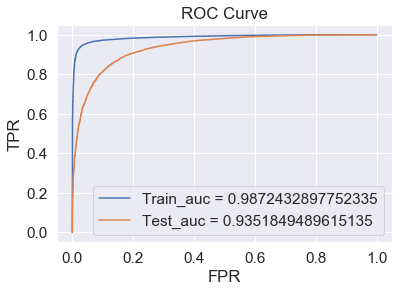

In [174]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(bow_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

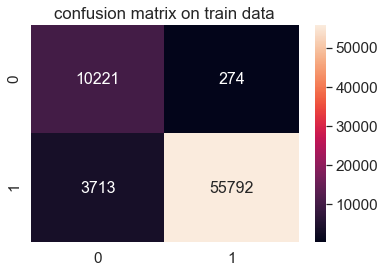

In [175]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

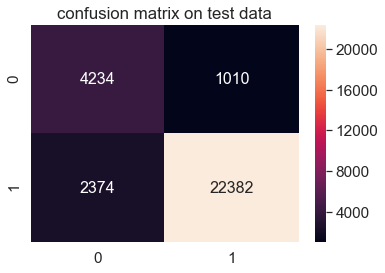

In [176]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [178]:
#showing how sparcity varies when C changes with L1 reg.
list=[1000,100,10,1,0.1,0.1,0.01]
for c in list:
    clf=LogisticRegression(C=c,penalty='l1',class_weight='balanced')
    clf.fit(bow_train,Y_train)
    Y_pred=clf.predict(bow_test)

    print("with C : ",c,"and l1 regularizer")
    print("Accuracy on test %.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
    print("nozero weights :",np.count_nonzero(clf.coef_))

with C :  1000 and l1 regularizer
Accuracy on test 84.24f%
nozero weights : 15180
with C :  100 and l1 regularizer
Accuracy on test 86.80f%
nozero weights : 12582
with C :  10 and l1 regularizer
Accuracy on test 88.72f%
nozero weights : 6736
with C :  1 and l1 regularizer
Accuracy on test 87.55f%
nozero weights : 1616
with C :  0.1 and l1 regularizer
Accuracy on test 83.38f%
nozero weights : 320
with C :  0.1 and l1 regularizer
Accuracy on test 83.38f%
nozero weights : 320
with C :  0.01 and l1 regularizer
Accuracy on test 69.35f%
nozero weights : 35


In [205]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tpositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(unigram,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						positive
________________________________________________________________________________________________
	-51.7231	capsi          				44.6143	undeni         
	-49.1908	162            				36.1331	doubleshot     
	-48.6648	vagan          				32.9330	___________    
	-47.9806	glare          				31.2380	clasico        
	-47.5613	loaf2          				30.2517	pricier        
	-47.3081	shapegav       				28.4249	delish         
	-47.1986	3qt            				28.3985	daddi          
	-47.0453	commod         				27.8957	inca           
	-46.1313	insuffici      				26.4270	deduct         
	-42.5636	shekel         				26.1681	hanov          
	-42.0663	laptop         				25.8823	container      
	-39.1281	gind           				25.8132	francisco      
	-37.0997	geeeeeeeeeez   				25.6672	shinier        
	-36.4149	yadayadayada   				25.3166	roca           
	-36.3412	deliveredin    				25.1965	keeper         
	-35.5530	crv            				24.7308	ingeni         
	-35.2603	eckridg        				

# Tfidf

In [32]:
%time
from sklearn.feature_extraction.text import TfidfVectorizer
#text to Tfidf
tfidf=TfidfVectorizer()
tfidf_train=tfidf.fit_transform(X_train)
tfidf_test=tfidf.transform(X_test)

#preprocessing
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_test=preprocessing.normalize(tfidf_test)

print("shape of train ",tfidf_train.shape)
print("shape of test ",tfidf_test.shape)

Wall time: 0 ns
shape of train  (70000, 45452)
shape of test  (30000, 45452)


In [33]:
#10 fold crossvalidaion
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)
for train,cv in tscv.split(tfidf_train):
    print(tfidf_train[train].shape,tfidf_train[cv].shape)

(6370, 45452) (6363, 45452)
(12733, 45452) (6363, 45452)
(19096, 45452) (6363, 45452)
(25459, 45452) (6363, 45452)
(31822, 45452) (6363, 45452)
(38185, 45452) (6363, 45452)
(44548, 45452) (6363, 45452)
(50911, 45452) (6363, 45452)
(57274, 45452) (6363, 45452)
(63637, 45452) (6363, 45452)


## Applying LR with L2 regularizer

In [34]:
%time
clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l2']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best param ",gsv.best_params_)

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished


best score 93.45f%
best param  {'C': 1, 'penalty': 'l2'}


In [35]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

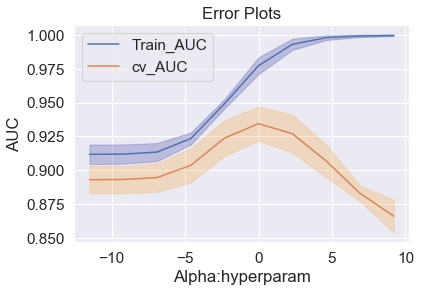

In [36]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [183]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l2',class_weight='balanced')

clf.fit(tfidf_train,Y_train)
Y_pred1=clf.predict(tfidf_train)
Y_pred2=clf.predict(tfidf_test)

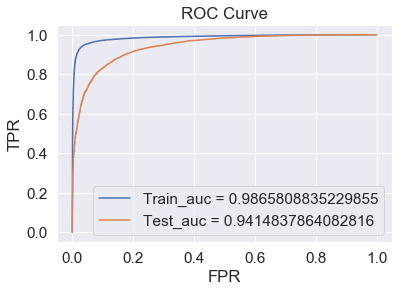

In [184]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(tfidf_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(tfidf_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

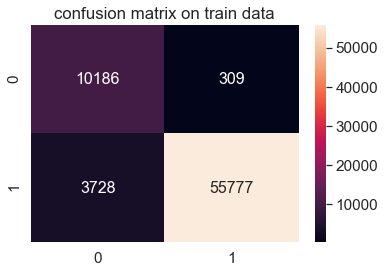

In [185]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

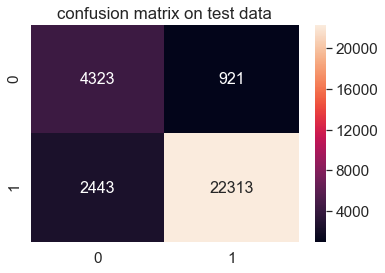

In [186]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

## Peturbation Test

In [187]:
from scipy.sparse import find
weights1=find(clf.coef_[0])[2]
print(weights1[:50])

[-3.36934254  1.94013047  0.02371027 -0.38075991  0.30420192  0.30415652
 -0.02533789  0.02559589  0.11963589 -0.63142621 -0.0348928   0.01228928
  0.38221037  0.01290914  1.1306313   0.43519697 -1.21550222  0.41220334
  0.30677045  0.39885407 -0.31859522 -0.26359872 -0.04926072  0.05245075
  0.07155913  0.12399935  0.45041605  1.03353247 -0.20498184  0.1296666
 -2.83946772  0.03300612  0.20087873  0.04732662  0.02478353 -0.50721593
 -0.5071349  -0.52702073  0.00412501  0.27124238  0.13835889  0.01831111
  0.06848479  0.15047685 -1.15623653 -3.49908988  0.30413036 -0.78505649
 -1.10778074  0.0957687 ]


In [188]:
#adding small error to each nonzero element
X_train_t=tfidf_train
eps=np.random.uniform(low=-0.0001,high=0.0001,size=(find(X_train_t)[0].size))
a,b,c=find(X_train_t)

X_train_t[a,b]=eps+X_train_t[a,b]

In [201]:
clf=LogisticRegression(C=10,penalty='l2',class_weight='balanced')
clf.fit(X_train_t,Y_train)
Y_pred=clf.predict(tfidf_test)

print("Accuracy on test :%0.3ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("non zero weight ",np.count_nonzero(clf.coef_))

Accuracy on test :88.790f%
non zero weight  45452


In [190]:
weights2=find(clf.coef_[0])[2]
print(weights2[0:50])

[-3.36873394  1.93949221  0.02371611 -0.38087024  0.30403723  0.30407611
 -0.02529488  0.0255679   0.11955458 -0.63105391 -0.03497176  0.01229184
  0.38201083  0.01290805  1.13087474  0.43488007 -1.21533209  0.41199178
  0.30676089  0.39920583 -0.31840808 -0.26289862 -0.04930473  0.05237736
  0.07161529  0.12395475  0.45048529  1.03313086 -0.20498978  0.12962888
 -2.83929005  0.03301835  0.20079053  0.04735718  0.02477061 -0.5071103
 -0.50719633 -0.52670276  0.0041275   0.27105227  0.13843275  0.01831541
  0.06851138  0.15021092 -1.15614288 -3.49957837  0.30418643 -0.78504418
 -1.10737511  0.09569387]


In [191]:
weights1=weights1+0.0000001
weights2=weights2+0.0000001

In [192]:
weight_diff=(abs(weights1-weights2)/weights1)*100
print(weight_diff[np.where(weight_diff>30)].size)

4


In [193]:
a=np.arange(1,45453)

In [194]:
j=[]
for i in range(10,110,10):
    j.append(int(round(np.percentile(a,i),0))-1)
    
print(j)
weight_diff[[i for i in j]]

[4545, 9090, 13635, 18180, 22725, 27271, 31816, 36361, 40906, 45451]


array([-0.63790797,  0.01654591,  0.03253392, -0.08647698,  0.06422354,
        0.05388899,  0.01534358,  0.2582534 ,  0.01940592,  0.05319973])

In [202]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tpositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						positive
________________________________________________________________________________________________
	-16.3634	worst          				15.2889	great          
	-11.6198	disappoint     				13.3495	best           
	-11.2486	terribl        				13.1384	delici         
	-10.4811	aw             				12.0320	perfect        
	-10.1636	threw          				11.1957	love           
	-9.8086	unfortun       				10.5413	excel          
	-9.7493	horribl        				10.1605	hook           
	-9.3514	return         				10.1125	yummi          
	-9.2900	disapoint      				9.7999	nice           
	-9.1628	disgust        				9.5264	beat           
	-9.1104	stale          				9.4563	favorit        
	-8.8374	bland          				9.3056	amaz           
	-8.7721	discard        				8.7698	addict         
	-8.3981	sleepless      				8.6610	skeptic        
	-7.8541	nespresso      				7.9765	yum            
	-7.8529	fals           				7.9430	fantast        
	-7.8390	mediocr        				7.8703	easi         

### With L1 Reg

In [179]:
%time
clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l1']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best param ",gsv.best_params_)

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 35.1min finished


best score 93.08f%
best param  {'C': 1, 'penalty': 'l1'}


In [180]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

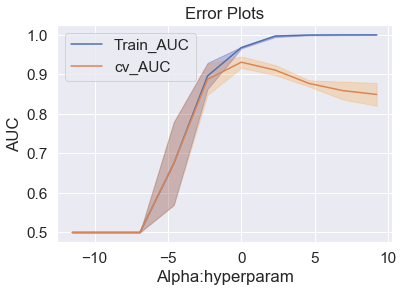

In [181]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [195]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')

clf.fit(tfidf_train,Y_train)
Y_pred1=clf.predict(tfidf_train)
Y_pred2=clf.predict(tfidf_test)

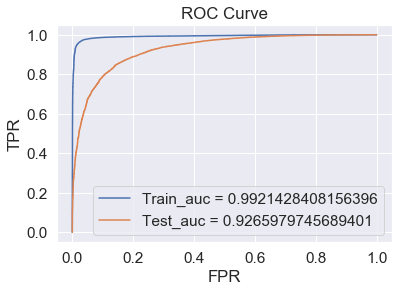

In [196]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(tfidf_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(tfidf_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

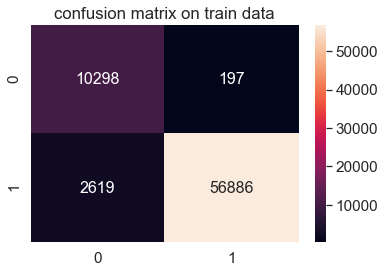

In [197]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

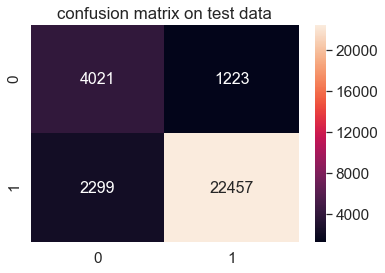

In [199]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [206]:
#showing how sparcity varies when C changes with L1 reg.
list=[1000,100,10,1,0.1,0.1,0.01]
for c in list:
    clf=LogisticRegression(C=c,penalty='l1',class_weight='balanced')
    clf.fit(tfidf_train,Y_train)
    Y_pred=clf.predict(bow_test)

    print("with C : ",c,"and l1 regularizer")
    print("Accuracy on test %.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
    print("nozero weights :",np.count_nonzero(clf.coef_))

with C :  1000 and l1 regularizer
Accuracy on test 87.20f%
nozero weights : 15723
with C :  100 and l1 regularizer
Accuracy on test 88.58f%
nozero weights : 13955
with C :  10 and l1 regularizer
Accuracy on test 89.95f%
nozero weights : 9107
with C :  1 and l1 regularizer
Accuracy on test 89.49f%
nozero weights : 2250
with C :  0.1 and l1 regularizer
Accuracy on test 85.88f%
nozero weights : 331
with C :  0.1 and l1 regularizer
Accuracy on test 85.88f%
nozero weights : 331
with C :  0.01 and l1 regularizer
Accuracy on test 69.32f%
nozero weights : 22


In [200]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tpositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						positive
________________________________________________________________________________________________
	-43.2006	loaf2          				37.7444	undeni         
	-38.6543	insuffici      				37.0042	oomph          
	-37.7348	shapegav       				28.4282	tilt           
	-37.6673	irat           				28.1440	daddi          
	-37.4695	isatori        				27.9276	lactose        
	-36.7675	mw             				27.5772	clasico        
	-35.4370	vagan          				26.9139	pricier        
	-34.1567	capsi          				26.5108	segment        
	-32.4637	glare          				25.4973	bittab         
	-31.9101	delud          				24.9557	emul           
	-29.7340	3qt            				24.7867	doubleshot     
	-29.6480	diahorrea      				24.4316	song           
	-29.3726	shippingbottom 				23.4264	inca           
	-29.1927	altered        				23.3033	grandfath      
	-27.7885	yadayadayada   				23.0504	feedbacki      
	-27.3328	results        				22.1857	xantham        
	-27.3316	truer          				

# Word2Vec

In [9]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())
    
print(X_train[0])
print("******************************************************")
print(list_of_sent_train[0])

rememb see show air televis year ago child sister later bought lp day im thirti someth use seri book &amp; song student teach preschool &amp; turn whole school purchas cd along book children 5 &amp; 2 tradit live
******************************************************
['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'lp', 'day', 'im', 'thirti', 'someth', 'use', 'seri', 'book', '&amp;', 'song', 'student', 'teach', 'preschool', '&amp;', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'book', 'children', '5', '&amp;', '2', 'tradit', 'live']


In [10]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    
print(X_test[0])
print("******************************************************")
print(list_of_sent_test[0])

first time order compani theyr fast great product def order flavor futur
******************************************************
['first', 'time', 'order', 'compani', 'theyr', 'fast', 'great', 'product', 'def', 'order', 'flavor', 'futur']


In [11]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)

In [12]:
type(w2v_model.wv.vocab)

dict

In [13]:
print(w2v_model.wv.vocab.keys())


dict_keys(['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'im', 'thirti', 'someth', 'use', 'seri', 'book', '&amp;', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'children', '5', '2', 'tradit', 'live', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'within', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch', 'wonder', 'amus', 'explor', 'incred', 'possibl', 'boundari', 'absurd', 'tell', 'tale', 'recent', 'dead', 'marri', 'coupl', 'sudden', 'get', 'led', 'world', 'supernatur', 'adam', 'barbara', 'maitland', 'alec', 'baldwin', 'geena', 'davi', 'discov', 'conflict', 'rather', 'human', 'imperfect', 'haunt', 'also', 'plagu', 'afterlif', 'unlik', 'film', 'project', 'seem', 'blin

In [14]:
w2v_words=[k for k in w2v_model.wv.vocab]
print("sample_words ",w2v_words[0:50])

sample_words  ['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'im', 'thirti', 'someth', 'use', 'seri', 'book', '&amp;', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'children', '5', '2', 'tradit', 'live', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'apart', 'infest', 'fruit', 'fli']


In [15]:
type(w2v_words)

list

In [16]:
w2v_model.wv.most_similar('tasti')

[('yummi', 0.766220211982727),
 ('delici', 0.7626129388809204),
 ('hearti', 0.7218126058578491),
 ('satisfi', 0.6660608053207397),
 ('nutriti', 0.6496449708938599),
 ('crunchi', 0.6448755264282227),
 ('nice', 0.6418840885162354),
 ('good', 0.6179956197738647),
 ('incred', 0.6067678928375244),
 ('dens', 0.601162314414978)]

# average Word2Vec


In [17]:
from tqdm import tqdm
sent_vectors_train=[]
for sent in tqdm(list_of_sent_train):
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:07<00:00, 550.69it/s]


70000
50


In [18]:
from tqdm import tqdm
sent_vectors_test=[]
for sent in tqdm(list_of_sent_test):
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:59<00:00, 507.47it/s]


30000
50


In [19]:
type(sent_vectors_train)

list

In [20]:
#normalize the avg w2v
sent_vectors_train=preprocessing.normalize(sent_vectors_train)
sent_vectors_test=preprocessing.normalize(sent_vectors_test)

print("shape of train ",sent_vectors_train.shape)
print("shape of test ",sent_vectors_test.shape)

shape of train  (70000, 50)
shape of test  (30000, 50)


## With L2 Reg

In [69]:
clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l2']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(sent_vectors_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best parameter ",gsv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.5s finished


best score 90.07f%
best parameter  {'C': 10, 'penalty': 'l2'}


In [70]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

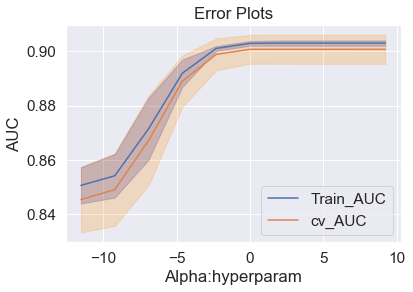

In [71]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [81]:
#testing accuracfy on test data
clf=LogisticRegression(C=1,penalty='l2',class_weight='balanced')

clf.fit(sent_vectors_train,Y_train)
Y_pred1=clf.predict(sent_vectors_train)
Y_pred2=clf.predict(sent_vectors_test)

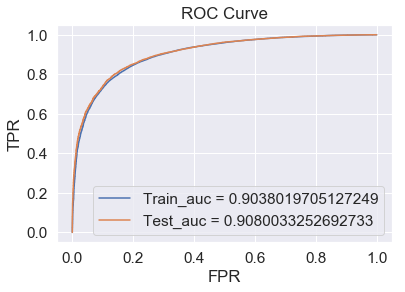

In [82]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(sent_vectors_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

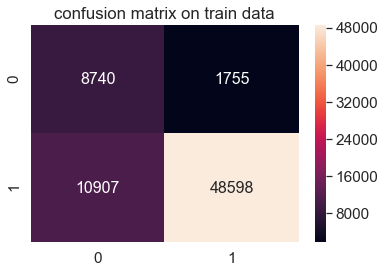

In [83]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

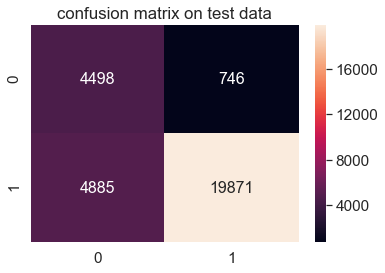

In [84]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [ ]:
##applying LR with L1 reg

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l1']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(sent_vectors_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best parameter ",gsv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished


best score 90.23f%
best parameter  {'C': 1, 'penalty': 'l1'}


In [24]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

In [25]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
X=np.log(C)
X

array([-11.51292546,  -9.21034037,  -6.90775528,  -4.60517019,
        -2.30258509,   0.        ,   2.30258509,   4.60517019,
         6.90775528,   9.21034037])

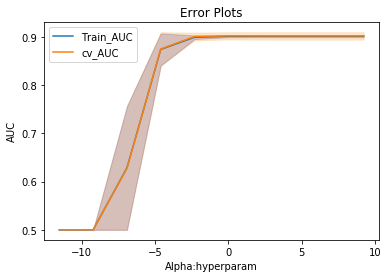

In [26]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [27]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')

clf.fit(sent_vectors_train,Y_train)
Y_pred1=clf.predict(sent_vectors_train)
Y_pred2=clf.predict(sent_vectors_test)

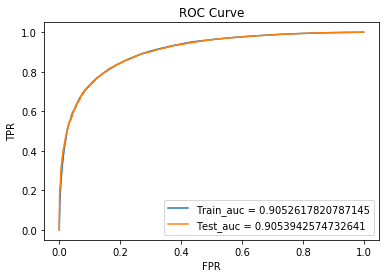

In [28]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(sent_vectors_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

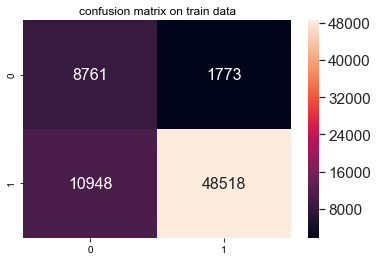

In [29]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

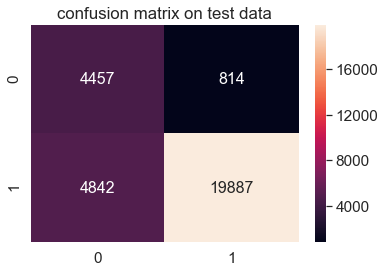

In [30]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# perturbation Test

In [101]:
print("non zero weights :",np.count_nonzero(clf.coef_))

non zero weights : 50


In [102]:
#non zero weights before adding noise
from scipy.sparse import find
weights1=find(clf.coef_[0])[2]

print(weights1[:50])

[ 0.60636715  4.4303099   0.29545942 -4.14362723  0.78839802 -0.35776522
 -1.20530735  0.50027386 -2.22540525  1.48793848  1.38883832 -1.53262651
  6.04679834 -2.97903354 -2.44703542 -1.08658666 -2.57227854  2.86191856
  5.0781128   6.38831067 -0.49585144  2.9377851  -2.84360926  0.2507956
  3.13270729 -0.11223374 -0.73211777  3.89883816  2.39945698 -0.68067209
  0.31133922 -1.09139508 -0.51453417 -1.1568967  -0.85793719  4.76559794
 -1.4223906   2.67417754  1.55589845  0.51194576 -1.19109906  1.19939701
  0.90795464  0.91517699 -0.98872355  3.07712731 -0.04709838  0.48761362
 -1.42985931 -4.39991769]


In [103]:
#adding random noise
X_train_t=sent_vectors_train
eps=np.random.uniform(low=-0.0001,high=0.0001,size=(find(X_train_t)[0].size))

a,b,c=find(X_train_t)
X_train_t[a,b]=eps+X_train_t[a,b]

In [104]:
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')
clf.fit(X_train_t,Y_train)
Y_pred=clf.predict(sent_vectors_test)

print("accuracy on test : %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("non zero weights :",np.count_nonzero(clf.coef_))

accuracy on test : 81.26f%
non zero weights : 50


In [105]:
weights2=find(clf.coef_[0])[2]
print(weights2)

[ 0.60662983  4.43027581  0.29595195 -4.14359561  0.78864457 -0.35765756
 -1.20486077  0.49990729 -2.22582445  1.48796795  1.38863352 -1.5324926
  6.04634359 -2.97928804 -2.44680154 -1.08648925 -2.57214126  2.86175582
  5.07770813  6.38813062 -0.49557481  2.93774612 -2.84329499  0.25093185
  3.13235015 -0.11236714 -0.73240883  3.89892008  2.39959996 -0.68047519
  0.31115932 -1.09153378 -0.51408921 -1.15661542 -0.85819149  4.76568786
 -1.42220551  2.67417891  1.55581526  0.51211151 -1.19112389  1.19938617
  0.90810037  0.91510822 -0.98842562  3.07757053 -0.0468444   0.48759378
 -1.42946772 -4.40036146]


In [106]:
weights_diff=(abs(weights2-weights1)/weights1)*100
print(weights_diff[np.where(weights_diff>30)].size)

0


In [107]:
print(weights_diff)

[ 4.33201873e-02  7.69643343e-04  1.66701004e-01 -7.62940289e-04
  3.12715070e-02 -3.00927734e-02 -3.70515255e-02  7.32741283e-02
 -1.88372325e-02  1.98084959e-03  1.47462586e-02 -8.73739058e-03
  7.52060106e-03 -8.54331731e-03 -9.55777610e-03 -8.96516487e-03
 -5.33696621e-03  5.68638627e-03  7.96882458e-03  2.81833055e-03
 -5.57897378e-02  1.32661705e-03 -1.10518193e-02  5.43275041e-02
  1.14003194e-02 -1.18853800e-01 -3.97570291e-02  2.10123353e-03
  5.95883433e-03 -2.89285687e-02  5.77818687e-02 -1.27079745e-02
 -8.64783501e-02 -2.43130647e-02 -2.96405242e-02  1.88702718e-03
 -1.30126318e-02  5.12986532e-05  5.34644285e-03  3.23757661e-02
 -2.08486813e-03  9.04327404e-04  1.60507436e-02  7.51408788e-03
 -3.01321110e-02  1.44038636e-02 -5.39258706e-01  4.06817413e-03
 -2.73866945e-02 -1.00858029e-02]


In [ ]:
#there is no significant increase in weights

In [109]:
C=[1000,100,10,1,0.1,0.01,0.001,0.0001]
for c in C:
    clf=LogisticRegression(C=c,penalty='l1',class_weight='balanced')
    clf.fit(sent_vectors_train,Y_train)
    Y_pred=clf.predict(sent_vectors_test)
    print("accuracy on train : ",accuracy_score(Y_test,Y_pred))
    print("no of non zero weights : ",np.count_nonzero(clf.coef_))

accuracy on train :  0.8126
no of non zero weights :  50
accuracy on train :  0.8126
no of non zero weights :  50
accuracy on train :  0.8126
no of non zero weights :  50
accuracy on train :  0.8126
no of non zero weights :  50
accuracy on train :  0.8125
no of non zero weights :  49
accuracy on train :  0.8032
no of non zero weights :  30
accuracy on train :  0.6739666666666667
no of non zero weights :  4
accuracy on train :  0.1748
no of non zero weights :  0


# Avg Tfidf

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)

dictionary = dict(zip(model.get_feature_names(),model.idf_.tolist()))

In [112]:
dictionary.keys()

dict_keys(['00', '000', '0000', '000001', '000111052bulk', '0001bottl', '000mg', '000s', '000scovill', '001', '0099', '00am', '00at', '00dollar', '00for', '00gr', '00i', '00noth', '00pm', '00the', '00what', '01', '01069', '011', '017', '018', '0188', '02', '02115', '025913', '03', '0300', '03510', '035273', '038', '03885', '03885the', '04', '042608460503serv', '043', '0461', '04691', '0471168572', '0472066978', '04820', '05', '052', '05715', '06', '060', '0623', '0625', '0631', '06799', '06oz', '07', '07003', '07003and', '0738551856', '074', '075', '08', '080', '0810', '084', '085', '08873', '089', '08oz', '08so', '09', '090', '0913', '0cholesterol', '0clock', '0f', '0g', '0g12', '0g5', '0gcarbohydrates', '0gcholest', '0gcholesterol', '0gingredients', '0gmonounsat', '0gnow', '0gpolyunsat', '0gpolyunsatur', '0gprotein', '0gr', '0gsatur', '0gsodium', '0gsugar', '0gtotal', '0gtran', '0gvitamin', '0gwater', '0high', '0iu', '0lb', '0mcg', '0mg', '0mg0', '0mgfat', '0mgfructos', '0mggalactos'

In [113]:

tfidf_feat = model.get_feature_names()

tfidf_vectors_train= []; 
row=0;
for sent in tqdm(list_of_sent_train):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            if word in dictionary:
                vec = w2v_model.wv[word]                      
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:41<00:00, 433.27it/s]


In [114]:

#tfidf_feat = model.get_feature_names()

tfidf_vectors_test= []; 
row=0;
for sent in tqdm(list_of_sent_test):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            if word in dictionary:
                vec = w2v_model.wv[word]                      
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:09<00:00, 433.35it/s]


In [115]:
tfidf_vectors_train=preprocessing.normalize(tfidf_vectors_train)
tfidf_vectors_test=preprocessing.normalize(tfidf_vectors_test)

print("shape of train ",tfidf_vectors_train.shape)
print("shape of test ",tfidf_vectors_test.shape)

shape of train  (70000, 50)
shape of test  (30000, 50)


## applying LR with L2 Reg.

In [119]:
clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l2']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_vectors_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best params ",gsv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   52.2s finished


best score 87.35f%
best params  {'C': 10, 'penalty': 'l2'}


In [120]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

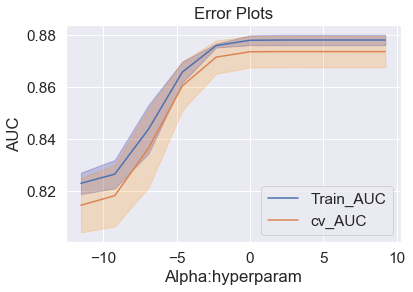

In [121]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [142]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l2',class_weight='balanced')

clf.fit(tfidf_vectors_train,Y_train)
Y_pred1=clf.predict(tfidf_vectors_train)
Y_pred2=clf.predict(tfidf_vectors_test)

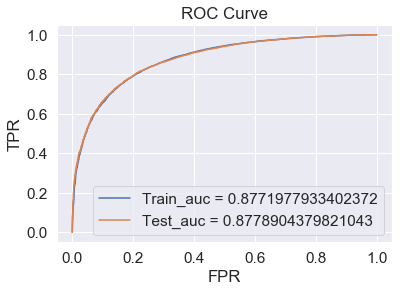

In [143]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(tfidf_vectors_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(tfidf_vectors_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

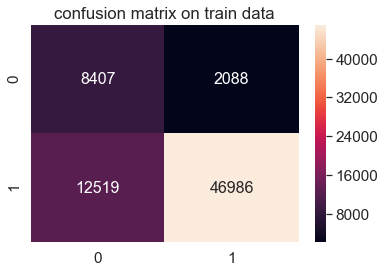

In [144]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

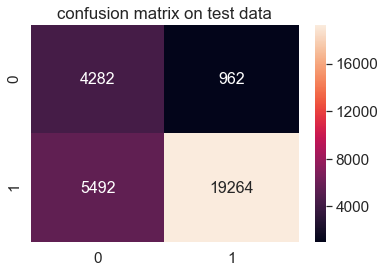

In [145]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

## with L1 Reg

In [148]:

clf=LogisticRegression(class_weight='balanced')
param_grid={'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
           'penalty':['l1']}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_vectors_train,Y_train)

print("best score %0.2ff%%"%(gsv.best_score_*100))
print("best params ",gsv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


best score 87.35f%
best params  {'C': 10, 'penalty': 'l1'}


In [149]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

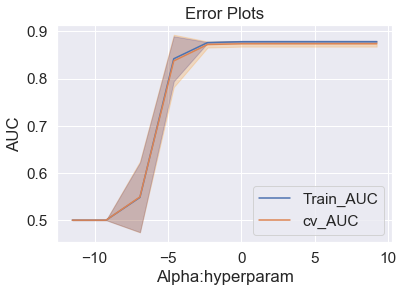

In [150]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [151]:
#testing accuracfy on test data
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')

clf.fit(tfidf_vectors_train,Y_train)
Y_pred1=clf.predict(tfidf_vectors_train)
Y_pred2=clf.predict(tfidf_vectors_test)

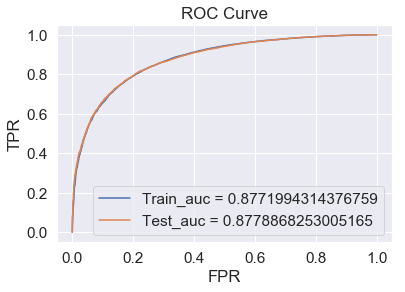

In [152]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(tfidf_vectors_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(tfidf_vectors_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

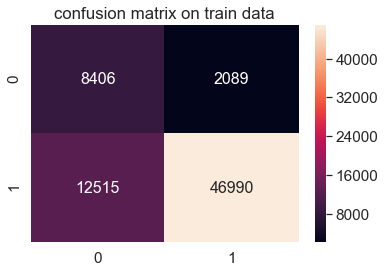

In [153]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

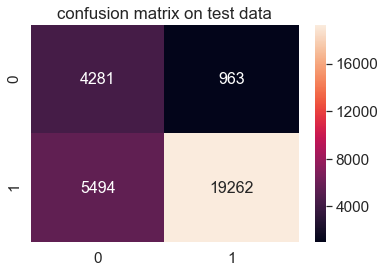

In [154]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# Peturbation Test

In [159]:
print("Non zero weights",np.count_nonzero(clf.coef_))

Non zero weights 50


In [161]:
weights1=find(clf.coef_[0])[2]
print(weights1[:50])

[ 0.72865719  4.06015846  0.53279144 -3.45133158  1.22358328  0.10608177
 -1.20374988  0.61267558 -1.74482325  1.25419     0.52853977 -0.24433767
  5.30616277 -3.57822422 -1.28900062 -1.21659265 -2.28319947  2.84808735
  4.64987838  5.83505786 -0.35532873  3.15706424 -2.21810916  0.08095975
  2.47932115  0.31393802 -0.35444014  3.72655109  2.45660186  0.01675945
 -0.17035181 -1.31686591 -0.41235359 -1.50986021 -0.795956    3.78128422
 -0.84839164  1.91485456  1.59292257  0.39216748 -1.33865784  1.37311002
  0.7151527   0.39780841 -1.28125319  2.24190791 -0.15802851  0.81210056
 -0.76068118 -4.05164233]


In [163]:
X_train_t=tfidf_vectors_train
eps=np.random.uniform(low=-0.0001,high=0.0001,size=(find(X_train_t)[0].size))
a,b,c=find(X_train_t)
X_train_t[a,b]=eps+X_train_t[a,b]

In [164]:
clf=LogisticRegression(C=10,penalty='l1',class_weight='balanced')
clf.fit(tfidf_vectors_train,Y_train)
Y_pred=clf.predict(tfidf_vectors_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("Non zeroweights ",np.count_nonzero(clf.coef_))

accuracy on test 78.48f%
Non zeroweights  50


In [165]:
weights2=find(clf.coef_[0])[2]
print(weights2[:50])

[ 0.7288601   4.06013793  0.53274956 -3.45143581  1.22382451  0.10608669
 -1.20376463  0.61273373 -1.74501961  1.2542174   0.52827688 -0.24413011
  5.30630981 -3.57779307 -1.28898194 -1.21663932 -2.28302354  2.84814142
  4.64978164  5.83511312 -0.35558133  3.15708012 -2.21775722  0.08118339
  2.47972004  0.31411952 -0.35452334  3.72651024  2.45676667  0.01669354
 -0.17028211 -1.31727946 -0.41258783 -1.51037716 -0.79605426  3.78131219
 -0.84837504  1.91518195  1.59262395  0.39194662 -1.33849128  1.37322185
  0.7151205   0.39775622 -1.28147248  2.24178958 -0.15833796  0.81194053
 -0.76095422 -4.05152134]


In [166]:
weights_diff=(abs(weights2-weights1)/weights1)*100
print(weights_diff[np.where(weights_diff>30)].size)

0


In [167]:
print(weights_diff)

[ 0.02784644  0.00050575  0.007862   -0.00301997  0.01971567  0.00464035
 -0.00122496  0.00949158 -0.01125395  0.00218455  0.04973976 -0.08494878
  0.0027711  -0.01204928 -0.00144917 -0.00383625 -0.00770548  0.0018985
  0.00208047  0.00094697 -0.07108975  0.000503   -0.01586684  0.27624474
  0.01608857  0.05781373 -0.02347393  0.00109639  0.00670915  0.39326409
 -0.04091484 -0.03140463 -0.05680564 -0.03423818 -0.01234507  0.00073952
 -0.00195765  0.01709749  0.01874663  0.05631719 -0.01244246  0.00814439
  0.00450227  0.0131203  -0.01711496  0.00527788 -0.19582007  0.0197061
 -0.03589462 -0.00298629]


### Observation :-
there is no significant changes in the weights


In [169]:
#showing how sparcity varies when C changes with L1 reg.
list=[1000,100,10,1,0.1,0.1,0.01]
for c in list:
    clf=LogisticRegression(C=c,penalty='l1')
    clf.fit(tfidf_vectors_train,Y_train)
    Y_pred=clf.predict(tfidf_vectors_test)

    print("with C : ",c,"and l1 regularizer")
    print("Accuracy on test %.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
    print("nozero weights :",np.count_nonzero(clf.coef_))

with C :  1000 and l1 regularizer
Accuracy on test 86.70f%
nozero weights : 50
with C :  100 and l1 regularizer
Accuracy on test 86.70f%
nozero weights : 50
with C :  10 and l1 regularizer
Accuracy on test 86.68f%
nozero weights : 50
with C :  1 and l1 regularizer
Accuracy on test 86.67f%
nozero weights : 49
with C :  0.1 and l1 regularizer
Accuracy on test 86.52f%
nozero weights : 43
with C :  0.1 and l1 regularizer
Accuracy on test 86.52f%
nozero weights : 43
with C :  0.01 and l1 regularizer
Accuracy on test 85.39f%
nozero weights : 21


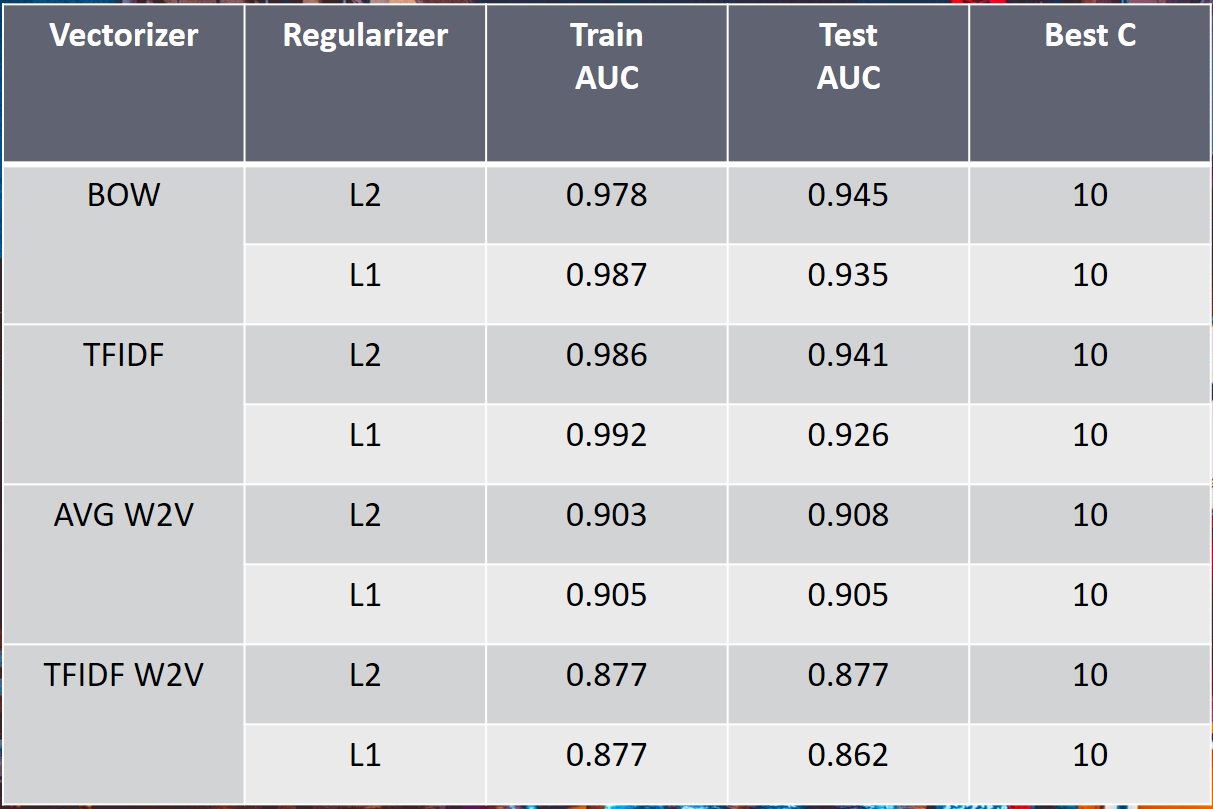

In [1]:
from IPython.display import Image
Image(filename="LR.png",height=500,width=500)

## Conclusion:-

- Unigram Vectorizer gave the best result with 0.978 train auc and 0.945 test auc
- There isn't any significance difference in scores wheather we use L1 Regularizer or L2 Regularizer
- Sparcity significantly increase while using L1 regularizer for BOW and Tfidf
- But in case of avg.w2v anf Tfidf w2v L1 regularizer doesn't play vital role in increasing sparcity
  as the length of vectors is very low.
- There is no sign of significance weight difference of features
- Hence no headache of multicolinearity.
- In case of feature importance, the models trained along with L1 regularizer gave much weight to some features that can't be interpreted But L2 regularizer gave best results.